# Préparation des données + EDA + PCA Pipeline

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pickle

In [2]:
# Charger le jeu de données
df = pd.read_csv("../data/customer_churn_train.csv")
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


### These datasets contains 12 feature columns. In detail, these are:
    CustomerID:  A unique identifier for each customer
    Age:  The age of the customer
    Gender:  Gender of the customer
    Tenure:  Duration in months for which a customer has been using the company's products or services
    Usage Frequency:  Number of times that the customer has used the company’s services in the last month
    Support Calls:  Number of calls that the customer has made to the customer support in the last month
    Payment Delay:  Number of days that the customer has delayed their payment in the last month
    Subscription Type:  Type of subscription the customer has choosen
    Contract Length:  Duration of the contract that the customer has signed with the company
    Total Spend:  Total amount of money the customer has spent on the company's products or services
    Last Interaction:  Number of days since the last interaction that the customer had with the company
    Churn:  Binary label indicating whether a customer has churned (1) or not (0)

In [3]:
# Vérifier la structure des données (dtypes)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [4]:
# Analyse des valeurs manquantes
df.isna().sum().sort_values(ascending=False)

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [5]:
# Vérifiez cette ligne vide
df[df.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Vérifier s'il y a des lignes en double
df[df.duplicated()]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn


In [7]:
# Supprimer les lignes vides
df = df.dropna(how="all")
df.isna().sum().sort_values(ascending=False)

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [8]:
# Vérifier la répartition de la variable cible (le churn est-il déséquilibré ?)
df['Churn'].value_counts(normalize=True)

Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64

D’après les vérifications précédentes, la répartition du churn est **relativement équilibrée**.
Bien que, dans de nombreux cas réels, le churn soit souvent très faible (10–20%), notre dataset présente :  
- ≈ 57% de classes positives (1) → un léger déséquilibre
- ≈ 43% de classes négatives (0)

Ce niveau de déséquilibre reste modéré et ne nécessite pas l’utilisation de SMOTE.
Cependant, dans les modèles sensibles au déséquilibre (Logistic Regression, XGBoost, etc.), on pourra envisager l’option :
class_weight="balanced"

afin d’améliorer la prise en compte des classes minoritaires.

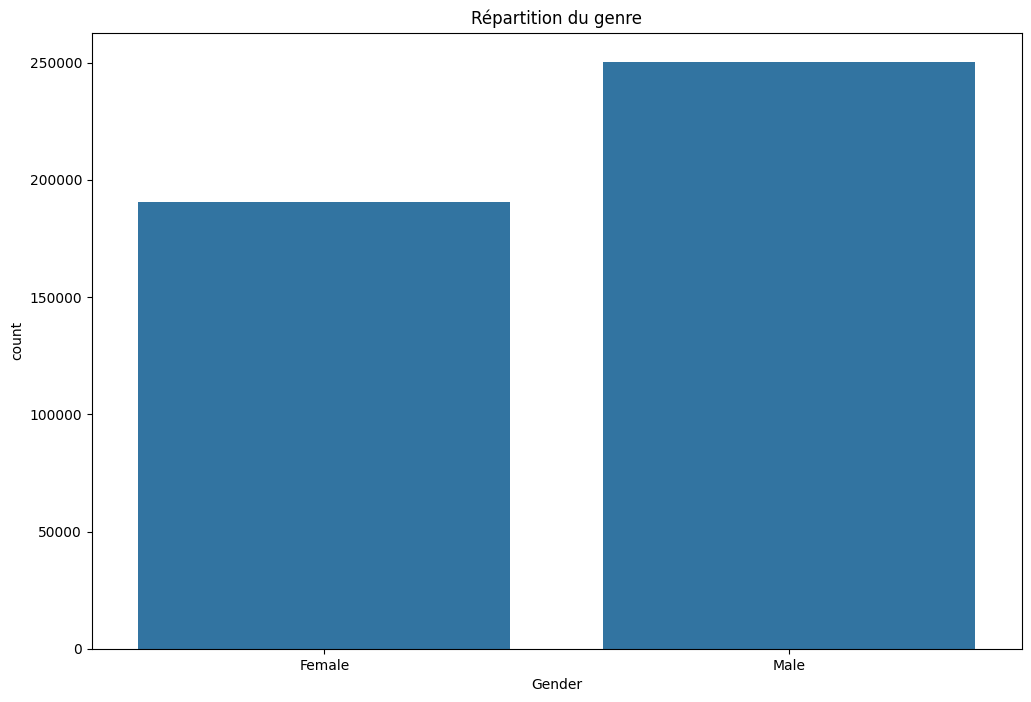

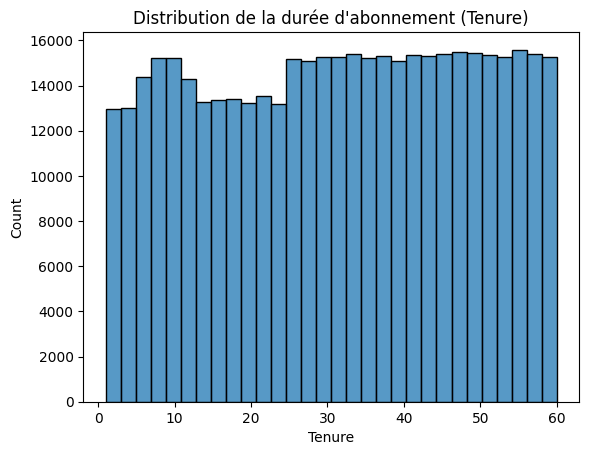

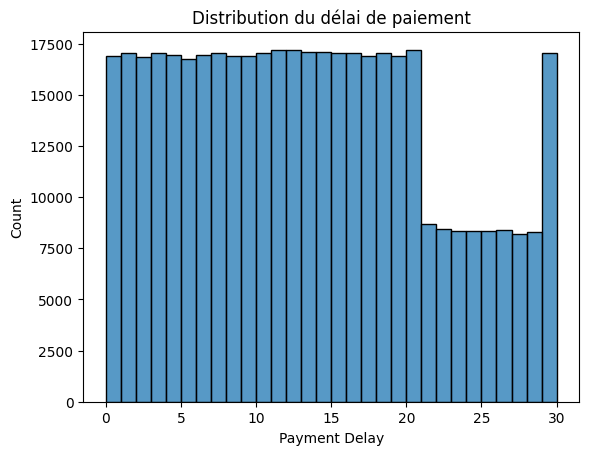

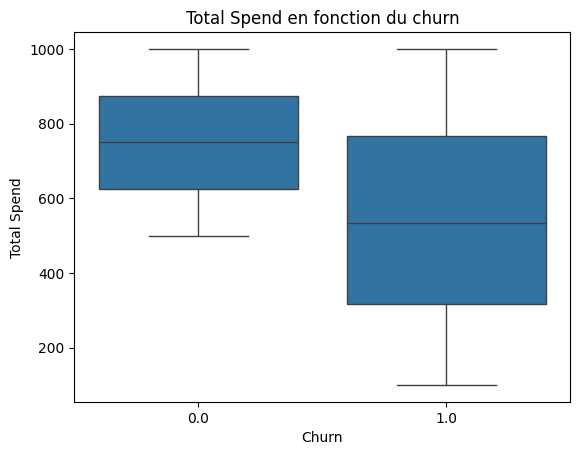

In [9]:
# Visualisation initiale
plt.figure(figsize=(12, 8))

# 1. Répartition du genre
sns.countplot(data=df, x="Gender")
plt.title("Répartition du genre")
plt.show()

# 2. Distribution de la durée d'abonnement (Tenure)
sns.histplot(df["Tenure"], bins=30)
plt.title("Distribution de la durée d'abonnement (Tenure)")
plt.show()

# 3. Distribution du délai de paiement
sns.histplot(df["Payment Delay"], bins=30)
plt.title("Distribution du délai de paiement")
plt.show()

# 4. Boîte à moustaches de Total Spend selon le churn
sns.boxplot(data=df, x="Churn", y="Total Spend")
plt.title("Total Spend en fonction du churn")
plt.show()


## Construct PCA embedding pipeline
Nous devons construire :  
- Détermination de la liste des caractéristiques
- Pour les variables numériques → `StandardScaler`
- Pour les variables catégorielles → `OneHotEncoder`
- Pour du texte (le cas échéant) → intégrations / traitement TF-IDF
- Enfin → Réduction de dimension avec `PCA` (généralement entre 10 et 20 dimensions)

In [10]:
# Détermination de la liste des caractéristiques ：

# Les valeurs sont des nombres (entiers/flottants), leur magnitude est significative et peuvent être additionnées ou soustraites etc.
numeric_features = [
    "Age",
    "Tenure",
    "Usage Frequency",
    "Support Calls",
    "Payment Delay",
    "Total Spend",
    "Last Interaction",
]

# Les valeurs ici eprésentent des catégories/options et ne peuvent pas être directement comparées en termes d'ampleur.
categorical_features = [
    "Gender",
    "Subscription Type",
    "Contract Length",
]

df = df.drop(columns=["CustomerID"])  # supprimer ID inutile

In [11]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pca = PCA(n_components=10, random_state=42)

# Mettre en place un pipeline complet
full_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("pca", pca)
])

In [12]:
# Transformation combinée de X en vecteurs réduits via PCA
# Extraire les variables d'entrée et cibles
X = df[numeric_features + categorical_features]
y = df["Churn"]
X_emb = full_pipeline.fit_transform(X)
X_emb.shape

(440832, 10)

In [13]:
# Construire ref_data.csv 
pca_cols = [f"PCA_{i+1}" for i in range(X_emb.shape[1])]

df_ref = pd.DataFrame(X_emb, columns=pca_cols)
df_ref["target"] = y.values

df_ref.to_csv("../data/ref_data.csv", index=False)

## Enregistrer le pipeline pour les appels API avenir
Visualiser les résultats de l'ACP, examiner les deux premières dimensions de l'ACP et observer si différentes étiquettes sont séparées de manière préliminaire.  

In [14]:
with open("../artifacts/embedding_pipeline.pickle", "wb") as f:
    pickle.dump(full_pipeline, f)

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

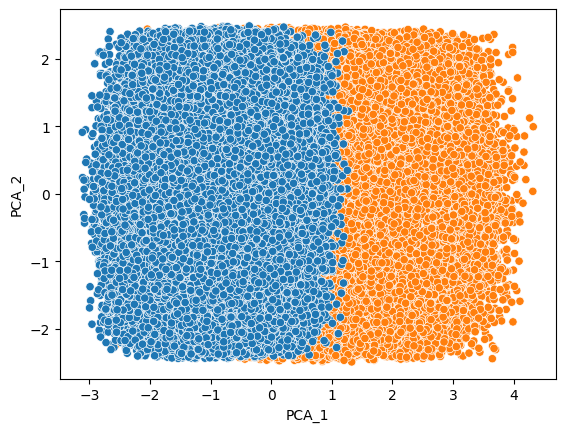

In [16]:
# Visualiser les résultats de l'ACP
sns.scatterplot(x=df_ref["PCA_1"], y=df_ref["PCA_2"], hue=df_ref["target"], legend=False)